In [ ]:
import os
import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf
import shutil
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score, classification_report

from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.models import load_model
from PIL import Image
from matplotlib import pyplot as plt

In [ ]:
# Define parameters
im_height = 100
im_width = 100
batch_size = 32

# Define data path
data_path = "../gtsrb-german-traffic-sign/versions/1/"

In [ ]:
# Define CSV file path
csv_file = data_path + "whichSign.csv"

# Load the CSV file / # ClassId >= 9
df = pd.read_csv(csv_file)
df = df[df['ClassId'] >= 9]

df['FullPath'] = data_path + df['Path']

# Adjust labels: ClassId 9 becomes 0, and ClassId 42 becomes 33
df['AdjLabel'] = df['ClassId'] - 9

# Extract arrays for file paths, ROI coordinates, and adjusted labels
paths = df['FullPath'].values
roi_x1 = df['Roi.X1'].values.astype(np.int32)
roi_y1 = df['Roi.Y1'].values.astype(np.int32)
roi_x2 = df['Roi.X2'].values.astype(np.int32)
roi_y2 = df['Roi.Y2'].values.astype(np.int32)
labels = df['AdjLabel'].values

# Create a tf.data.Dataset from these arrays
dataset = tf.data.Dataset.from_tensor_slices((paths, roi_x1, roi_y1, roi_x2, roi_y2, labels))

# Function to load an image, crop it based on ROI, resize, and normalize
def load_and_crop_image(path, x1, y1, x2, y2, label):
    # Read and decode the image file
    image_data = tf.io.read_file(path)
    img = tf.image.decode_image(image_data, channels=3)
    
    # Ensure ROI coordinates are integers
    x1 = tf.cast(x1, tf.int32)
    y1 = tf.cast(y1, tf.int32)
    x2 = tf.cast(x2, tf.int32)
    y2 = tf.cast(y2, tf.int32)
    
    # Compute crop dimensions
    crop_width = x2 - x1
    crop_height = y2 - y1
    
    # Crop the image to the ROI. Note: crop_to_bounding_box expects (offset_height, offset_width, height, width)
    cropped = tf.image.crop_to_bounding_box(img, offset_height=y1, offset_width=x1,
                                            target_height=crop_height, target_width=crop_width)
    
    # Resize the cropped image to the model's input size
    resized = tf.image.resize(cropped, [im_height, im_width])
    
    # Normalize pixel values to [0,1]
    normalized = resized / 255.0
    return normalized, label

# Map the load_and_crop_image function to the dataset
dataset = dataset.map(load_and_crop_image, num_parallel_calls=tf.data.AUTOTUNE)
# Using num_parallel_calls=tf.data.AUTOTUNE lets TensorFlow decide how many operations to run in parallel, which speeds up processing.

# Shuffle the dataset and split into training (80%) and validation (20%)
dataset_size = len(paths)
val_size = int(0.2 * dataset_size)
train_size = dataset_size - val_size

dataset = dataset.shuffle(buffer_size=dataset_size, reshuffle_each_iteration=True)
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)

# Batch and prefetch for performance
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Overall, these steps ensure that the data is efficiently processed, shuffled, split, and loaded in batches
# improving both training performance and consistency.

Adjusted labels range: 0 33


In [ ]:
# Load the VGG16 base model without the classification head
base_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False, 
                                         input_shape=(im_height, im_width, 3))
base_model.trainable = False  # Freeze the base model for initial training

# Custom classification model on top of the base model
model = tf.keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(34, activation='softmax')  # 34 output neurons for multi-class classification
])

# Compile the model with sparse categorical crossentropy loss for integer labels
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
# Set up callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_whichSign_model.keras', monitor='val_loss', save_best_only=True)
]

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=7,
    callbacks=callbacks
)

Epoch 1/7
651/651 ━━━━━━━━━━━━━━━━━━━━ 737s 1s/step - accuracy: 0.6942 - loss: 1.1055 - val_accuracy: 0.8754 - val_loss: 0.3927
Epoch 2/7
651/651 ━━━━━━━━━━━━━━━━━━━━ 707s 1s/step - accuracy: 0.8951 - loss: 0.3419 - val_accuracy: 0.9427 - val_loss: 0.1873
Epoch 3/7
651/651 ━━━━━━━━━━━━━━━━━━━━ 722s 1s/step - accuracy: 0.9198 - loss: 0.2634 - val_accuracy: 0.9539 - val_loss: 0.1423
Epoch 4/7
651/651 ━━━━━━━━━━━━━━━━━━━━ 639s 966ms/step - accuracy: 0.9361 - loss: 0.2139 - val_accuracy: 0.9550 - val_loss: 0.1373
Epoch 5/7
651/651 ━━━━━━━━━━━━━━━━━━━━ 587s 891ms/step - accuracy: 0.9439 - loss: 0.1839 - val_accuracy: 0.9731 - val_loss: 0.0893
Epoch 6/7
651/651 ━━━━━━━━━━━━━━━━━━━━ 598s 906ms/step - accuracy: 0.9447 - loss: 0.1747 - val_accuracy: 0.9687 - val_loss: 0.1001
Epoch 7/7
651/651 ━━━━━━━━━━━━━━━━━━━━ 602s 912ms/step - accuracy: 0.9494 - loss: 0.1589 - val_accuracy: 0.9783 - val_loss: 0.0739


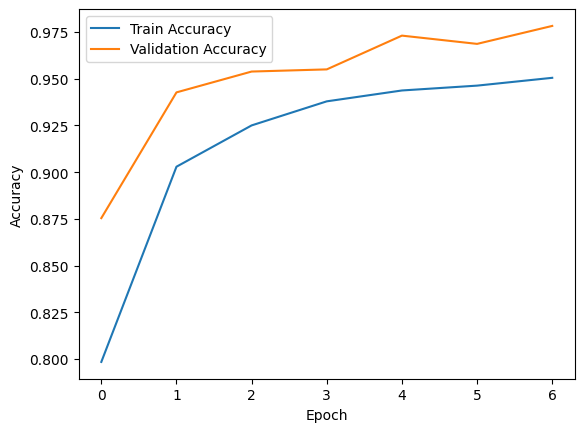

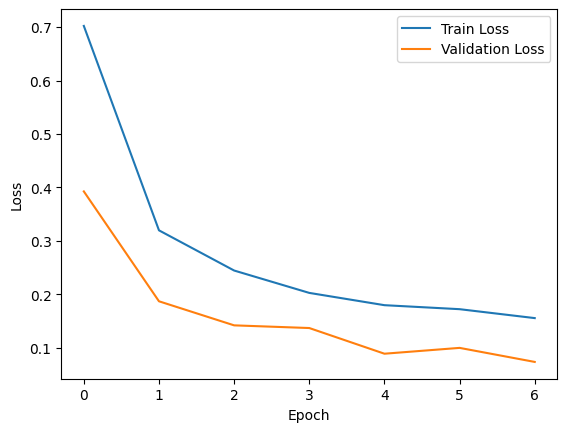

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
csv_file_test = data_path + "whichSign_test.csv" 

# Load the CSV file
df_test = pd.read_csv(csv_file_test)

# Prepend the base directory to the relative image paths
df_test['FullPath'] = data_path + df_test['Path']
df_test['AdjLabel'] = df_test['ClassId'] - 9


# Extract arrays for file paths, ROI coordinates, and labels
paths = df_test['FullPath'].values
roi_x1 = df_test['Roi.X1'].values.astype(np.int32)
roi_y1 = df_test['Roi.Y1'].values.astype(np.int32)
roi_x2 = df_test['Roi.X2'].values.astype(np.int32)
roi_y2 = df_test['Roi.Y2'].values.astype(np.int32)
labels = df_test['AdjLabel'].values

# Create a tf.data.Dataset from these arrays
dataset_test = tf.data.Dataset.from_tensor_slices((paths, roi_x1, roi_y1, roi_x2, roi_y2, labels))

# Map the custom function to the dataset
test_ds = dataset_test.map(load_and_crop_image, num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch for performance
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [25]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.2f}")

813/813 ━━━━━━━━━━━━━━━━━━━━ 578s 711ms/step - accuracy: 0.9683 - loss: 0.0994
Test Accuracy: 0.98


In [3]:
mapping = {
  0: "Interdiction de dépasser",
  1: "interdiction de dépasser pour poids lourd",
  2: "Voie prioritaire",
  3: "priorité à droite",
  4: "Laisser passer",
  5: "Stop",
  6: "Interdit au véhicules",
  7: "Interdit au poids lourd",
  8: "Sens interdit",
  9: "Attention",
  10: "Attention virage à gauche",
  11: "Attention virage à droite",
  12: "Succession de virage",
  13: "Dos d'ane",
  14: "Risque dérapage",
  15: "Voie rétrécie",
  16: "Attention travaux",
  17: "Feu tricolore",
  18: "Attention piéton",
  19: "Attention enfants",
  20: "Attention vélo",
  21: "Attention gel",
  22: "Attention animaux",
  23: "Fin d'interdiction",
  24: "Tourner à droite",
  25: "Tourner à gauche",
  26: "Continuer tout droit",
  27: "Tout Droit ou Droite",
  28: "Tout Droit ou Gauche",
  29: "Placer vous à droite",
  30: "Placer vous à gauche",
  31: "Rond point",
  32: "Fin Interdiction de dépasser",
  33: "Fin interdiction de dépasser poids lourds"
}

In [ ]:
# Gather true labels from the test dataset
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

# Generate prediction probabilities using the model
y_pred_probs = model.predict(test_ds)

# Convert prediction probabilities to predicted class labels (using argmax)
y_pred = np.argmax(y_pred_probs, axis=1)

813/813 ━━━━━━━━━━━━━━━━━━━━ 558s 686ms/step


Confusion Matrix:
[[1410   16    0 ...    0    0    1]
 [  15 1931    0 ...    0    0    0]
 [   0    0 1257 ...    0    0    0]
 ...
 [   0    0    0 ...  333    0    0]
 [   0    0    0 ...    0  207    9]
 [   0    0    0 ...    0    0  237]]

Classification Report:
                                           precision    recall  f1-score   support

                 Interdiction de dépasser       0.99      0.96      0.97      1470
interdiction de dépasser pour poids lourd       0.99      0.96      0.97      2010
                         Voie prioritaire       0.99      0.95      0.97      1320
                        priorité à droite       1.00      0.99      1.00      2100
                           Laisser passer       1.00      1.00      1.00      2160
                                     Stop       1.00      1.00      1.00       780
                    Interdit au véhicules       1.00      0.99      1.00       630
                  Interdit au poids lourd       1.00      0.98   

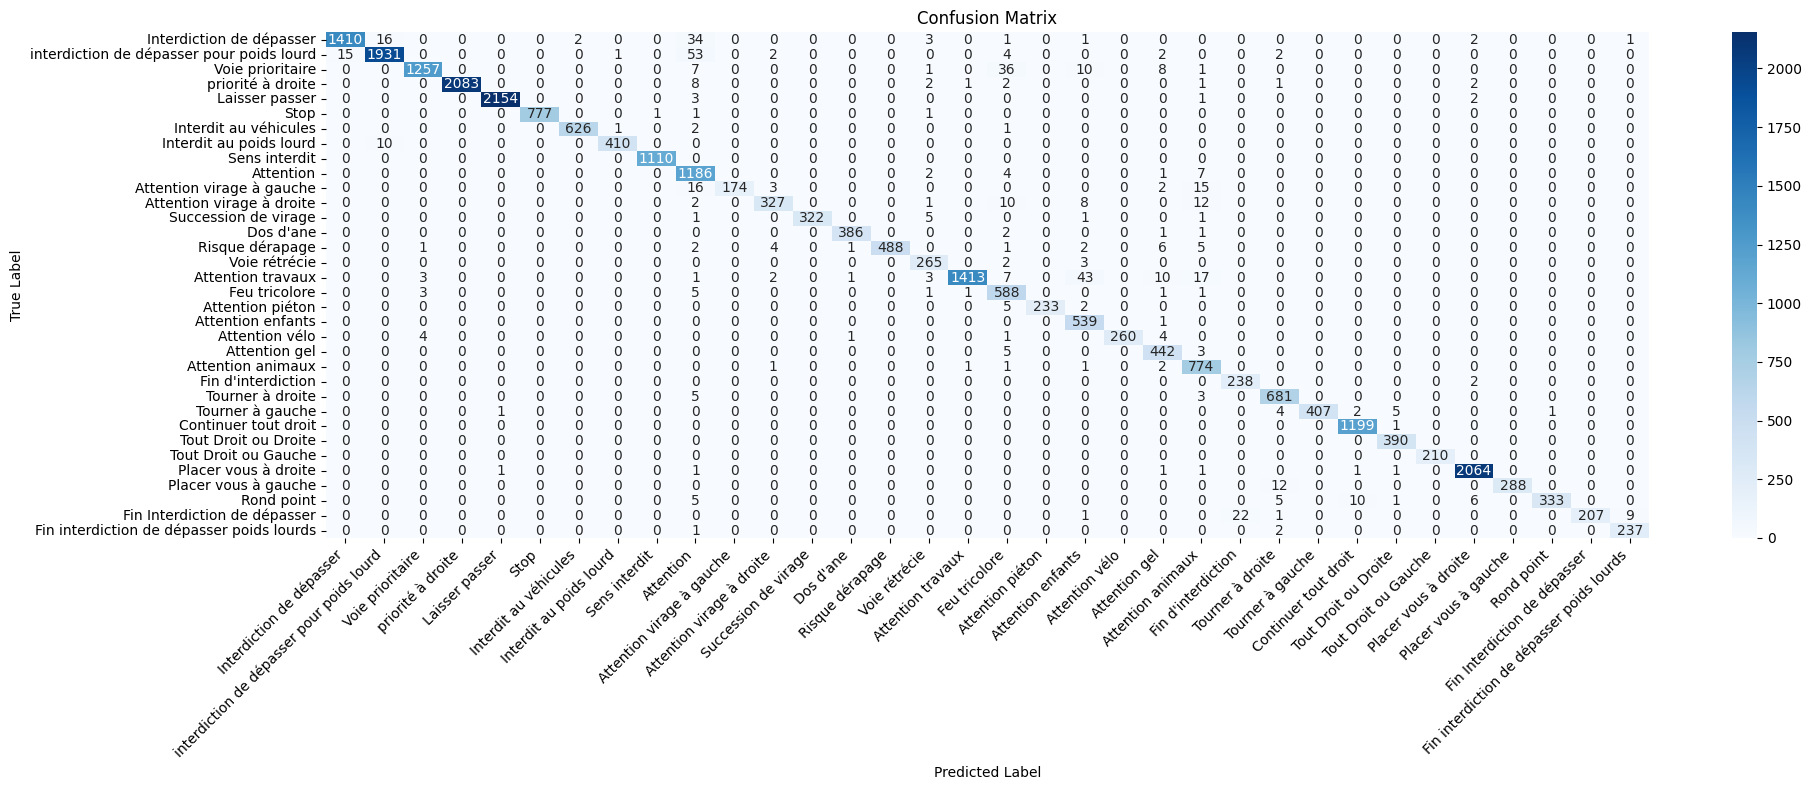

In [28]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Create target names using the mapping dictionary (ordered by key)
target_names = [mapping[k] for k in sorted(mapping.keys())]

# Print a classification report with the mapped class names
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# Visualize the confusion matrix
plt.figure(figsize=(20, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=target_names, 
            yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
model = tf.keras.models.load_model('../modelsROI/best_whichSign_model.keras')
batch_size=32

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Predicted sign: Continuer tout droit


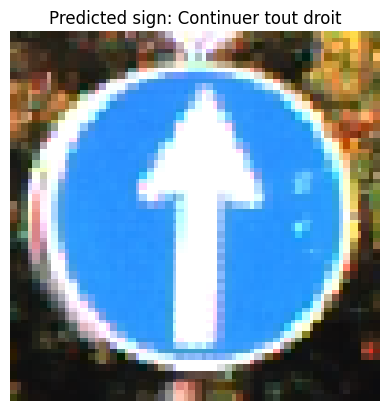

In [ ]:
# Path to image file
# img_path = "../gtsrb-german-traffic-sign/versions/1/Meta/12.png"
# img_path = "./whichSign_dataset_test//9/00009_00000_00020.png"
# img_path = "./whichSign_dataset_test//18/00018_00000_00020.png"
# img_path = "./whichSign_dataset_test//14/00014_00000_00020.png"
# img_path = "./whichSign_dataset_test//12/00012_00000_00020.png"
img_path = "./whichSign_dataset_test//35/00035_00000_00020.png"

# Load the image and resize it
img = image.load_img(img_path, target_size=(im_height, im_width))
img_array = image.img_to_array(img)

# Normalize the image to [0, 1]
img_array = img_array / 255.0

# Add a batch dimension (model expects a batch of images)
img_batch = np.expand_dims(img_array, axis=0)

# Make prediction
prediction_probs = model.predict(img_batch)[0]  # output shape should be (33,)
predicted_index = np.argmax(prediction_probs)  # this gives an index from 0 to 32

# Adjust the index to match mapping keys by adding 9
actual_class = predicted_index
predicted_sign = mapping[actual_class]

print("Predicted sign:", predicted_sign)
result = f"Predicted sign: {predicted_sign}"

# Display the image with the prediction result
plt.imshow(img)
plt.title(result)
plt.axis("off")
plt.show()


ROI coordinates: 5 6 44 45


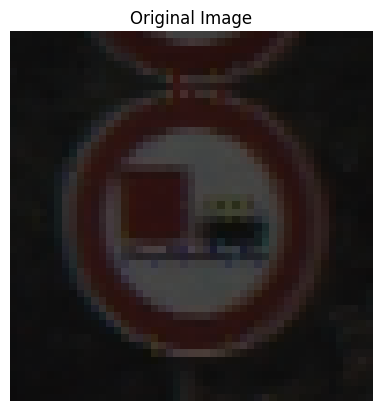

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
Predicted sign: interdiction de dépasser pour poids lourd


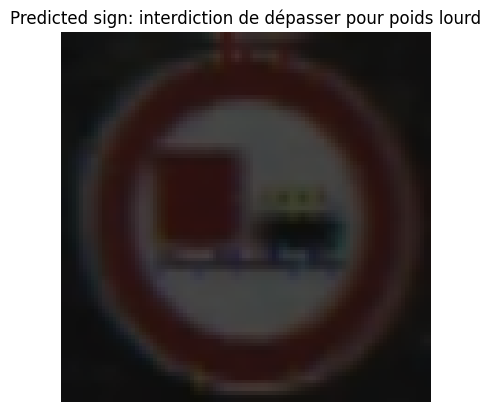

In [ ]:
# Load the CSV file
csv_file = data_path + "whichSign_test.csv"
df = pd.read_csv(csv_file)

df['FullPath'] = data_path + df['Path']

# Function to get ROI coordinates from the CSV for a given image path
def get_roi_for_image(image_path, df):
    # Look up the row matching the full image path
    row = df[df['FullPath'] == image_path]
    if row.empty:
        print("No ROI found for image:", image_path)
        return None
    else:
        roi_x1 = int(row['Roi.X1'].values[0])
        roi_y1 = int(row['Roi.Y1'].values[0])
        roi_x2 = int(row['Roi.X2'].values[0])
        roi_y2 = int(row['Roi.Y2'].values[0])
        return roi_x1, roi_y1, roi_x2, roi_y2

# Specify the image path
test_img_path = data_path + "Train/10/00010_00000_00020.png"  

# Retrieve ROI coordinates for this image from the CSV
roi = get_roi_for_image(test_img_path, df)
if roi is None:
    raise ValueError("Could not find ROI for the provided image path.")
else:
    roi_x1, roi_y1, roi_x2, roi_y2 = roi
    print("ROI coordinates:", roi_x1, roi_y1, roi_x2, roi_y2)

# Load the original image (without resizing)
img = image.load_img(test_img_path)
img_array = image.img_to_array(img)

# Display the original image
plt.imshow(img_array.astype(np.uint8))
plt.title("Original Image")
plt.axis("off")
plt.show()

# Crop the image using the ROI coordinates
cropped = tf.image.crop_to_bounding_box(
    img_array,
    offset_height=roi_y1,
    offset_width=roi_x1,
    target_height=roi_y2 - roi_y1,
    target_width=roi_x2 - roi_x1
)

# Resize the cropped ROI to the model's input size (100x100)
resized = tf.image.resize(cropped, [im_height, im_width])

# Normalize the image (scale pixel values to [0,1])
normalized = resized / 255.0

# Add a batch dimension (model expects a batch)
img_batch = np.expand_dims(normalized, axis=0)

# Make a prediction 
prediction_probs = model.predict(img_batch)[0]
predicted_class = np.argmax(prediction_probs)
predicted_sign = mapping.get(predicted_class, "Unknown")
print("Predicted sign:", predicted_sign)

# For display, convert normalized image back to 0-255 range
display_img = tf.cast(normalized * 255.0, tf.uint8).numpy()

plt.imshow(display_img)
plt.title(f"Predicted sign: {predicted_sign}")
plt.axis("off")
plt.show()